## Homework 3 - Josephine_He - 12/2021

#### HW3
Please do the following in a jupyter notebook
- There is a csv under the data folder called `hw3.csv`
- the goal of this hw is to calculate volumeUSD by chain

Some hints for this hw:
- volumeUSD = volume * close
- you will need to clean data
- visualize your data to better understand what is going on

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

pd.options.display.float_format='{:.2f}'.format

In [2]:
df = pd.read_csv('data/hw3.csv', index_col = 'ts')

In [3]:
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 14:00:00,22.41,22.49,22.08,22.35,31502.15,NaN,UNI,ETH
2021-12-02 23:00:00,4.80,4.80,4.74,4.78,73686.23,NaN,CRV,ETH
2021-12-10 15:00:00,182.49,NaN,175.21,175.86,73736.75,NaN,SOL,SOL
2021-12-10 18:00:00,3978.43,3989.74,3932.00,3972.34,18508.04,NaN,ETH,ETH
2021-12-08 21:00:00,193.32,194.24,192.56,193.15,69426.91,NaN,SOL,SOL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2667 entries, 2021-12-02 14:00:00 to 2021-12-06 07:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2667 non-null   float64
 1   high       2163 non-null   float64
 2   low        2378 non-null   float64
 3   close      2531 non-null   float64
 4   volume     2667 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2667 non-null   object 
 7   chain      2667 non-null   object 
dtypes: float64(6), object(2)
memory usage: 187.5+ KB


We can see there are 2667 total entries. 

1. Columns 'low', 'close' have missing volumns and 'columnUSD' has all null values. 
2. Column 'volumn' has no null values.

In [5]:
df1 = df.sort_index()

In [6]:
df1['chain'].value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

We know chain column is clean, with only 4 unique chains

In [7]:
df1['volume'].describe()

count       2667.00
mean      479421.89
std      1651197.03
min           67.18
25%         1324.25
50%        18869.09
75%       105988.19
max     32828498.67
Name: volume, dtype: float64

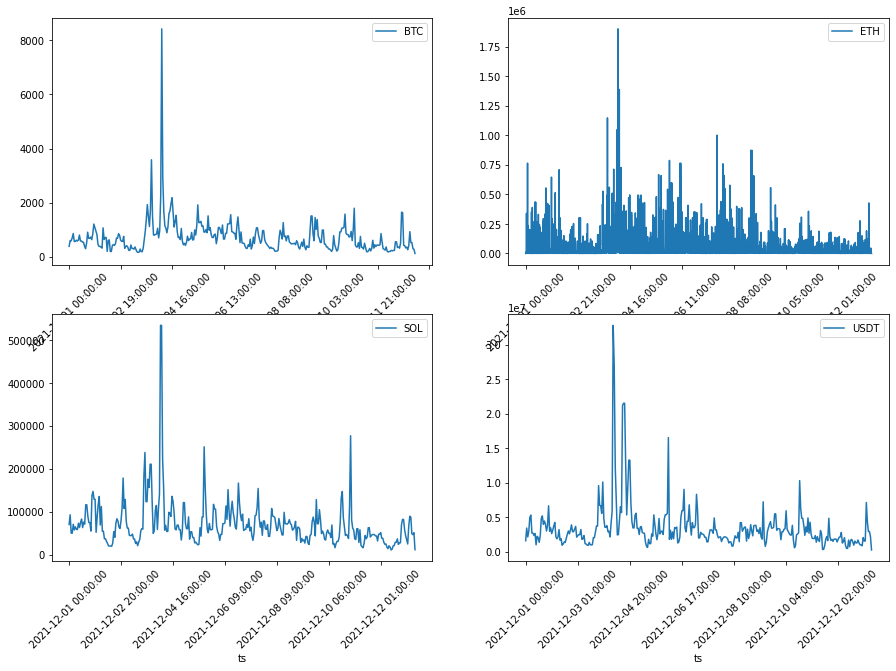

In [8]:
chains_in_df = df1['chain'].unique()

fig, axes = plt.subplots(nrows=math.ceil(chains_in_df.size / 2), ncols = 2, figsize=(15, 5*math.ceil(chains_in_df.size / 2)))

idx = 0
for label, df_chain in df1[['chain', 'volume']].groupby('chain'):
    df_chain['volume'].plot(ax=axes[idx//2, idx%2], label=label, rot=45)
    #plt.xticks(rotation=90)
    axes[idx//2, idx%2].legend();
    
    idx +=1 


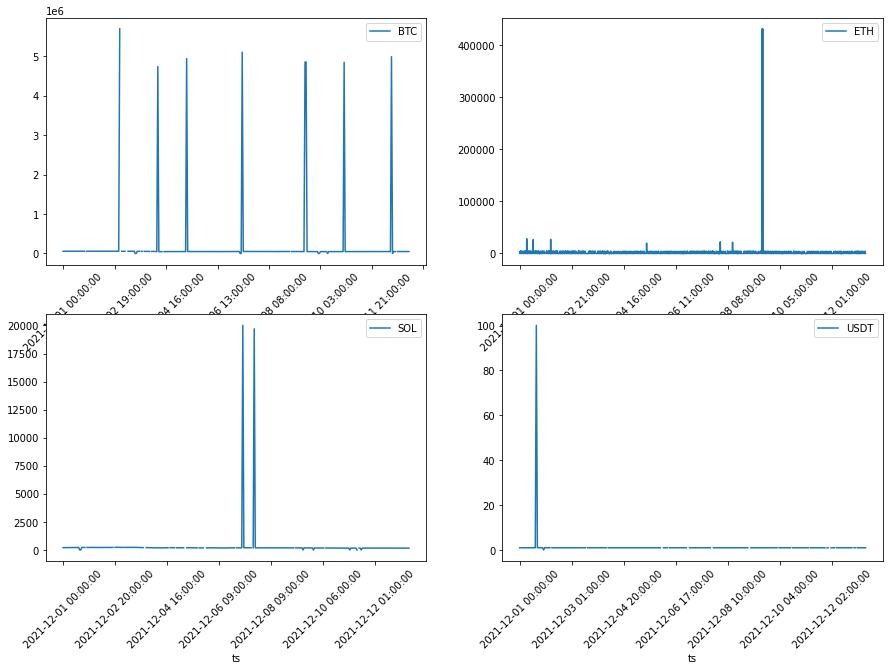

In [9]:
fig, axes = plt.subplots(nrows=math.ceil(chains_in_df.size / 2), ncols = 2, figsize=(15, 5*math.ceil(chains_in_df.size / 2)))

idx = 0
for label, df_chain in df1[['chain', 'close']].groupby('chain'):
    df_chain['close'].plot(ax=axes[idx//2, idx%2], label=label, rot=45)
    #plt.xticks(rotation=90)
    axes[idx//2, idx%2].legend();
    
    idx +=1

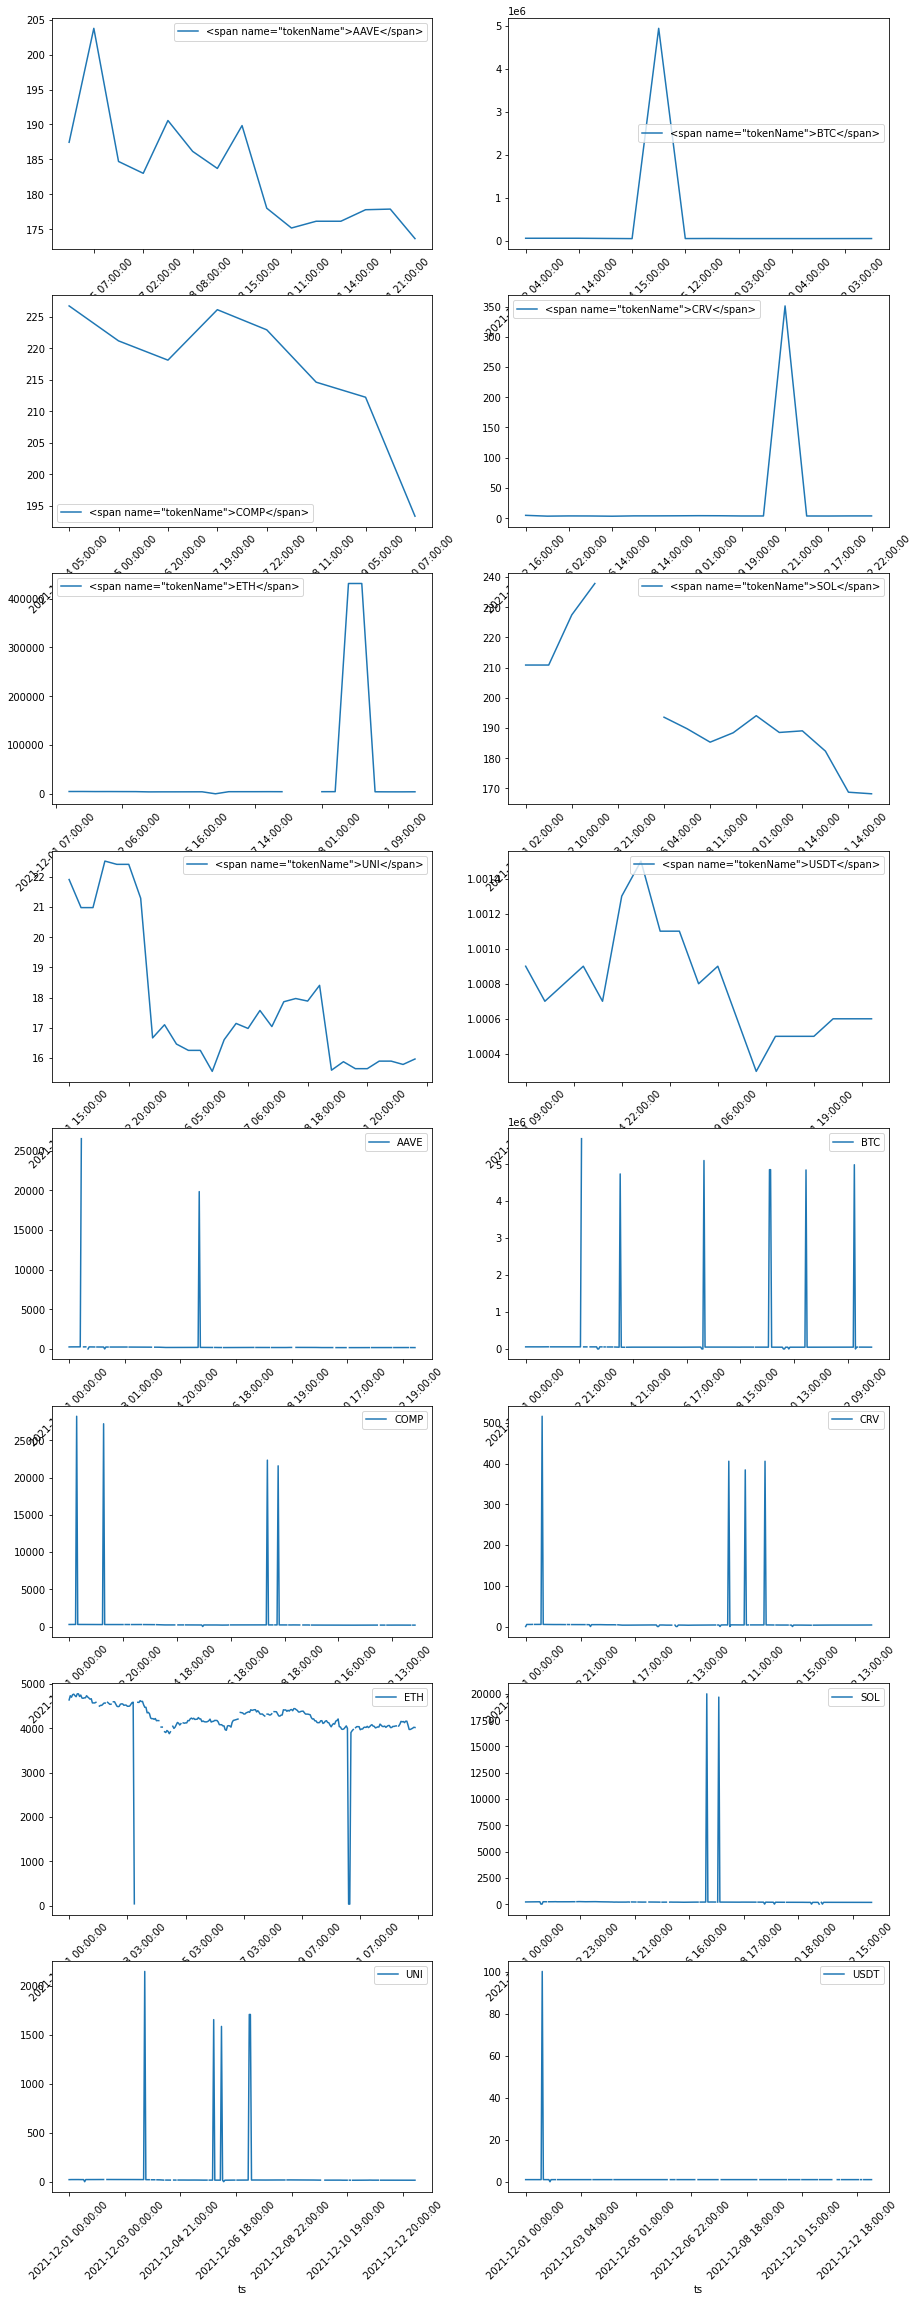

In [10]:
tokens_in_df = df1.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df1[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label, rot=45)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

We can see that there are nulls and outliers in the 'close' column.

In [11]:
df1.duplicated().sum()

307

We can see that there are duplicated rows

## Strategy:
1. remove duplicate rows
2. clean up 'token' column names so we don't have the ones with tags
3. use a heuristic for missing close price as average of high + low price of the token for the day, if available; if high or low prices are not available, use open price
4. find outliers in close prices and replace with step 3 logic
5. calculate volumeUSD
6. groupby chain and sum volumeUSD

1. remove duplicate rows

In [12]:
df1 = df1.drop_duplicates()

In [13]:
df1.duplicated().sum()

0

2. clean up 'token' column names so we don't have the ones with tags

In [14]:
df1.groupby('token').size()

token
<span name="tokenName">AAVE</span>     15
<span name="tokenName">BTC</span>      12
<span name="tokenName">COMP</span>      9
<span name="tokenName">CRV</span>      16
<span name="tokenName">ETH</span>      25
<span name="tokenName">SOL</span>      14
<span name="tokenName">UNI</span>      25
<span name="tokenName">USDT</span>     17
AAVE                                  280
BTC                                   283
COMP                                  286
CRV                                   279
ETH                                   270
SOL                                   281
UNI                                   270
USDT                                  278
dtype: int64

In [15]:
df1.loc[df1['token'].str.contains('<span name="tokenName">'), 'token'] = df1.loc[df1['token'].str.contains('<span name="tokenName">'), 'token'].str.extract('<span name="tokenName">(.*?)<\/span>')
# use loc to look for records with '<a>', then take 'token' column, and replace values with extracted value

In [ ]:
## Alternative way...
for token in ['BTC','COMP','CRV','SOL','USDT','UNI','AAVE','ETH']:
    df1 = df1.replace({'<span name="tokenName">'+token+'</span>': token})
df1['token'].value_counts()

In [16]:
df1.token.unique()

array(['SOL', 'COMP', 'AAVE', 'UNI', 'BTC', 'ETH', 'USDT', 'CRV', nan],
      dtype=object)

In [18]:
df1 = df1.dropna(subset=['token'])

In [19]:
df1.groupby('token').size()

token
AAVE    280
BTC     283
COMP    286
CRV     279
ETH     270
SOL     281
UNI     270
USDT    278
dtype: int64

In [20]:
df1.token.unique()

array(['SOL', 'COMP', 'AAVE', 'UNI', 'BTC', 'ETH', 'USDT', 'CRV'],
      dtype=object)

3. use a heuristic for missing close price as average of high + low price of the token for the day, if available; if high or low prices are not available, use open price

In [21]:
df1.loc[df1['close'].isnull(), 'close'] = 0.5 * (df1.loc[df1['close'].isnull(), 'high'] + df1.loc[df1['close'].isnull(), 'low'])

In [22]:
df1.close.isnull().sum()

32

In [23]:
df1.loc[df1['close'].isnull(), 'close'] = df1.loc[df1['close'].isnull(), 'open']

In [24]:
df1['close'].isnull().sum() ## or df1.close.isnull().sum()

0

4. find outliers in close prices and replace with step 3 logic

In [25]:
df1.loc[(df1.close / df1.open >= 2) | (df1.close / df1.open <= 0.02)].size

392

In [26]:
df1.loc[(df1.close / df1.open >= 2) | (df1.close / df1.open <= 0.02), 'close'] = 0.5 * (df1.loc[(df1.close / df1.open >= 2) | (df1.close / df1.open <= 0.02), 'high'] + 
                                                                                       df1.loc[(df1.close / df1.open >= 2) | (df1.close / df1.open <= 0.02), 'low'])

In [27]:
df1.loc[(df1.close / df1.open >= 2) | (df1.close / df1.open <= 0.02)].size

0

In [30]:
tokens_in_df = df1.token.unique()
tokens_in_df

array(['SOL', 'COMP', 'AAVE', 'UNI', 'BTC', 'ETH', 'USDT', 'CRV'],
      dtype=object)

In [31]:
pd.isnull(df1).sum()

open            0
high          421
low           236
close           9
volume          0
volumeUSD    2227
token           0
chain           0
dtype: int64

In [32]:
df1.loc[df1['close'].isnull()]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 16:00:00,1.00,NaN,1.00,NaN,5186434.22,NaN,USDT,USDT
2021-12-01 17:00:00,265.26,NaN,262.91,NaN,980.92,NaN,AAVE,ETH
2021-12-03 05:00:00,4.58,NaN,4.55,NaN,88072.82,NaN,CRV,ETH
2021-12-06 09:00:00,15.87,NaN,15.67,NaN,154397.14,NaN,UNI,ETH
2021-12-09 12:00:00,188.59,188.97,NaN,NaN,23319.76,NaN,SOL,SOL
2021-12-10 21:00:00,48123.29,48479.78,NaN,NaN,748.85,NaN,BTC,BTC
2021-12-10 23:00:00,3996.17,NaN,3953.77,NaN,8379.37,NaN,ETH,ETH
2021-12-11 06:00:00,171.00,NaN,169.62,NaN,34927.28,NaN,SOL,SOL
2021-12-12 14:00:00,49542.39,NaN,49534.71,NaN,342.67,NaN,BTC,BTC


In [33]:
df1.loc[df1['close'].isnull(), 'close'] = df1.loc[df1['close'].isnull(), 'open']

In [34]:
pd.isnull(df1).sum()

open            0
high          421
low           236
close           0
volume          0
volumeUSD    2227
token           0
chain           0
dtype: int64

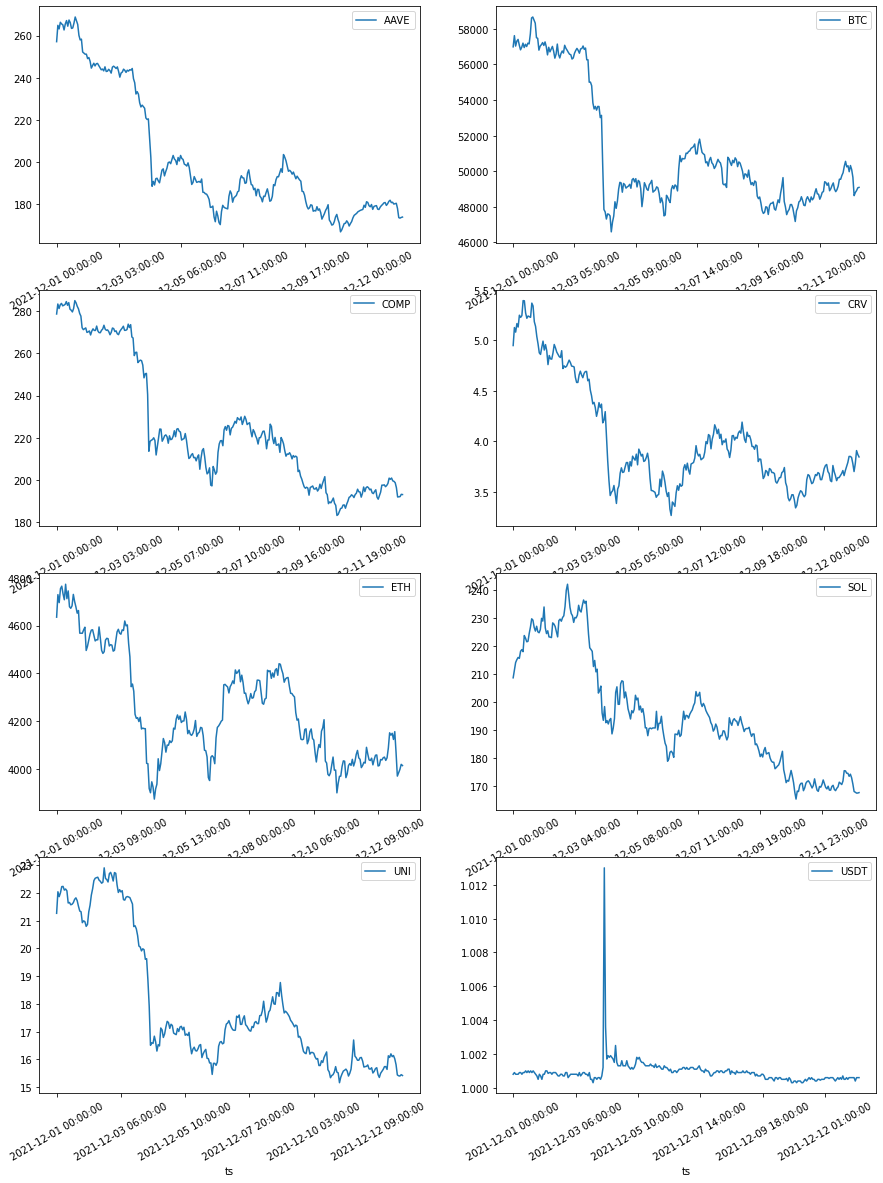

In [35]:
tokens_in_df = df1.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df1[['token', 'close']].groupby('token'):
    if 'token':
        df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label, rot=30)
        axes[idx // 2, idx % 2].legend()
    
    idx += 1

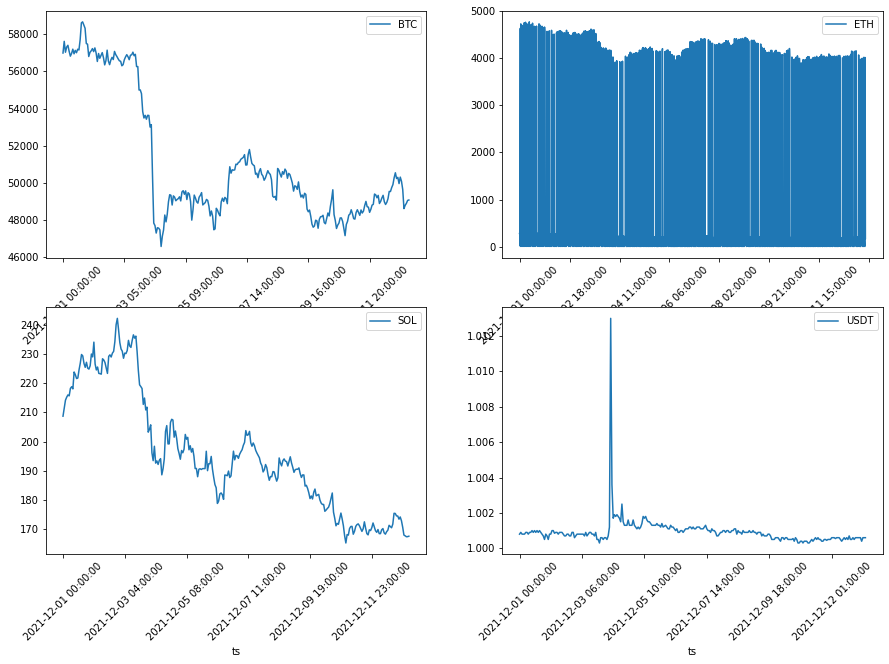

In [36]:
fig, axes = plt.subplots(nrows=math.ceil(chains_in_df.size / 2), ncols = 2, figsize=(15, 5*math.ceil(chains_in_df.size / 2)))

idx = 0
for label, df_chain in df1[['chain', 'close']].groupby('chain'):
    df_chain['close'].plot(ax=axes[idx//2, idx%2], label=label, rot=45)
    #plt.xticks(rotation=90)
    axes[idx//2, idx%2].legend();
    
    idx +=1

In [37]:
df1['volumeUSD'] = df1.volume * df1.close

In [39]:
df1.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,210.31,NaN,208.43,208.68,70031.62,14613917.92,SOL,SOL
2021-12-01 00:00:00,280.59,281.40,278.30,278.70,207.85,57927.52,COMP,ETH
2021-12-01 00:00:00,257.10,260.77,255.34,257.08,2730.30,701899.81,AAVE,ETH
2021-12-01 00:00:00,21.20,21.31,21.03,21.27,12406.13,263827.60,UNI,ETH
2021-12-01 00:00:00,57321.41,57451.05,56814.34,56987.97,388.48,22138801.82,BTC,BTC


In [40]:
df1.volumeUSD.isnull().sum()

0

In [44]:
df1.groupby('chain')['volumeUSD'].sum().to_frame()

,volumeUSD
chain,
BTC,10560605033.44
ETH,12553468644.05
SOL,3912667365.64
USDT,969641784.71


In [46]:
pd.reset_option('^display.', silent=True)